### Contributor: Sudesh Kumar Santhosh Kumar
- Email: sudeshkumar.santhoshkumar@lexisnexis.com
- Date: 27th June, 2023

Description:  This Notebook will show you how to fine-tune BERT for Named Entity Recognition. We'll be using the MIT Restaurant Dataset.

# Part I - Installation, Loading Dataset and Tokenization
---------------------------------

## S1. Setting up the Notebook


### 1.1. Basic Pre-requisites and Installations

If you're using this notebook on Google Colab, Don't forget to uncomment the following cell to install transformers library into the notebook. If you're using this notebook on your local machine through VS Code or Jupyter notebook, you need to do a "pip install -r requirements.txt" before running the following set of code blocks.

In [1]:
# !pip install transformers

### 1.2. Importing all necessary libraries

In [2]:
import textwrap
import random
import csv
import os
import wget
import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForTokenClassification, AdamW, BertConfig

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics




### 1.3. Connecting to GPU 

### In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [3]:
# Checking if there is a GPU Available.
if torch.cuda.is_available():

    device = torch.device(("cuda"))
    print(f"There are {torch.cuda.device_count()} available.")
    print(f"We will use the GPU: {torch.cuda.get_device_name(0)}")

else:
    print("No GPU available, using the CPU!")
    device = torch.device("cpu")

No GPU available, using the CPU!


## S2. Load Dataset from scikit-learn and Inspect it

### 2.1. Download the Dataset

In [4]:
print('Downloading dataset...')

# The URL for the *training* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttrain.bio'):
wget.download(url, './restauranttrain.bio')

# The URL for the *test* examples.
url = 'https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio'

# Download the file (if we haven't already)
#if not os.path.exists('./restauranttest.bio'):
wget.download(url, './restauranttest.bio')

'./restauranttest (1).bio'

## 2.2. NER Tags and IOB Format

Both the train and test datasets are single files containing restaurant-related text (mostly reviews and queries), where each word has a NER tag specifying it as one of the following restaurant-related entities:

- Amenity
- Cuisine
- Dish
- Hours
- Location
- Price
- Rating
- Restaurant_Name


The NER tag follows a special format used widely in NER literature called the [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)#:~:text=) (Inside, Outside, Beginning Format). This format gives us a way to not only tag entities, but to indicate which words are part of the same entity:

- **O**: this tag means the word is not part of an entity.
- **B**: this tag means the word is either a single-word entity name, or else the first word in a multi-word entity name.
- **I**: this tag means the word is part of a multi-word entity, but is not the first word in the full entity name.

For example:

| TAG | WORD  |
|---|---|
| O  | My  |
| O  | first  |
| O  |  name |
| O  |  is |
| B-Person  | John  |
|  O | and  |
| O  | my  |
| O  | full  |
| O  |  name |
| O  |  is |
| B-Person  | John  |
| I-Person  | A.  |
| I-Person  | Smith  |

Furthermore, as you can see above the **B** and **I** tags are used as prefixes before the entity types and can be used before any entity type you like, whether it's people or restaurants or countries. There are some variations of the IOB format that might use special tags for single-word entities or tags for words that are the last word in a multi-word entity. Different formats might confer small advantages on different kinds of datasets, but for now there's no need to worry if you're working on a dataset with a different tag format (as long as you are consistent!) 

Now, back to our dataset. The words in each review are separated by line, and reviews themselves are separated by blank lines. Each line that is not blank contains a word from the review and its NER tag:

| TAG | WORD  |
|---|---|
|  O | a   |
|  B-Rating | four  |
| I-Rating | star  |
|  O |  restaurant |
| B-Location  | with  |
| I-Location  | a  |
| B-Amenity  | bar  |
|    |    |
| O  | any  |
|  B-Cuisine |  bbq |
| O  | places  |
|  B-Hours | open  |
| I-Hours  | before  |
| I-Hours  | 5  |
|  B-Location |  nearby |



### 2.3. Parse Dataset

In [6]:
# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []

# Gather the set of unique labels.
unique_labels = set()

# Read the dataset line by line. Each line of the file
# is either empty or has two tokens, separated by a tab.
with open("./restauranttrain.bio", newline = '') as lines:                                                                                          
    
    # Use the `csv` class to split the lines on the tab character.
    line_reader = csv.reader(lines, delimiter='\t')
    
    # For each line in the file...
    for line in line_reader:
        print(line)
        # If we encounter a blank line, it means we've completed the previous 
        # sentence. 
        if line == []:

            # Add the completed sentence.
            sentences.append(tokens)
            labels.append(token_labels)           
    
            # Start a new sentence.
            tokens = []
            token_labels = []        

        else: 
            # Add the token and its label to the current sentence.
            tokens.append(line[1])
            token_labels.append(line[0])

            # Add the label to the set (no effect if it already exists).
            unique_labels.add(line[0])

['B-Rating', '2']
['I-Rating', 'start']
['O', 'restaurants']
['O', 'with']
['B-Amenity', 'inside']
['I-Amenity', 'dining']
[]
['O', '34']
[]
['B-Rating', '5']
['I-Rating', 'star']
['O', 'resturants']
['B-Location', 'in']
['I-Location', 'my']
['I-Location', 'town']
[]
['O', '98']
['B-Restaurant_Name', 'hong']
['I-Restaurant_Name', 'kong']
['O', 'restaurant']
['B-Price', 'reasonable']
['O', 'prices']
[]
['O', 'a']
['O', 'great']
['O', 'lunch']
['O', 'spot']
['O', 'but']
['B-Hours', 'open']
['I-Hours', 'till']
['I-Hours', '2']
['I-Hours', 'a']
['I-Hours', 'm']
['B-Restaurant_Name', 'passims']
['I-Restaurant_Name', 'kitchen']
[]
['O', 'a']
['O', 'place']
['O', 'that']
['O', 'serves']
['B-Dish', 'soft']
['I-Dish', 'serve']
['I-Dish', 'ice']
['I-Dish', 'cream']
[]
['O', 'a']
['O', 'restaurant']
['O', 'that']
['O', 'is']
['B-Rating', 'good']
['B-Amenity', 'for']
['I-Amenity', 'groups']
[]
['O', 'a']
['B-Dish', 'salad']
['O', 'would']
['O', 'make']
['O', 'my']
['O', 'day']
[]
['O', 'a']
['B-Cu

### Here are all of the unique labels in the dataset.

In [7]:
unique_labels

{'B-Amenity',
 'B-Cuisine',
 'B-Dish',
 'B-Hours',
 'B-Location',
 'B-Price',
 'B-Rating',
 'B-Restaurant_Name',
 'I-Amenity',
 'I-Cuisine',
 'I-Dish',
 'I-Hours',
 'I-Location',
 'I-Price',
 'I-Rating',
 'I-Restaurant_Name',
 'O'}

In [10]:
# Map each unique label to an integer.
label_map = {}

# For each label...
for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer.
    label_map[label] = i

In [11]:
label_map

{'B-Price': 0,
 'I-Price': 1,
 'I-Restaurant_Name': 2,
 'I-Dish': 3,
 'I-Hours': 4,
 'I-Cuisine': 5,
 'B-Restaurant_Name': 6,
 'I-Rating': 7,
 'B-Hours': 8,
 'B-Dish': 9,
 'B-Amenity': 10,
 'I-Location': 11,
 'O': 12,
 'B-Rating': 13,
 'B-Cuisine': 14,
 'B-Location': 15,
 'I-Amenity': 16}

### 2.3. Exploratory Data Analysis and Checking for imbalances in the dataset.

In [12]:
print(f"Total number of Sentences in the Train Data: {len(sentences)}")
print()
print("Example sentence:")
print ("    Tokens:", sentences[4])
print ("    Labels:", labels[4])

print ('\nSentence Tokens and Labels:')
for i in zip(sentences[4], labels[4]):
  print (i)

Total number of Sentences in the Train Data: 7660

Example sentence:
    Tokens: ['a', 'great', 'lunch', 'spot', 'but', 'open', 'till', '2', 'a', 'm', 'passims', 'kitchen']
    Labels: ['O', 'O', 'O', 'O', 'O', 'B-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'I-Hours', 'B-Restaurant_Name', 'I-Restaurant_Name']

Sentence Tokens and Labels:
('a', 'O')
('great', 'O')
('lunch', 'O')
('spot', 'O')
('but', 'O')
('open', 'B-Hours')
('till', 'I-Hours')
('2', 'I-Hours')
('a', 'I-Hours')
('m', 'I-Hours')
('passims', 'B-Restaurant_Name')
('kitchen', 'I-Restaurant_Name')


## S3. Tokenization using BertTokenizer.

### 3.1 Loading the BertTokenizer.

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

The dataset comes already “tokenized” in the sense that it’s split into lists of words.

There is still more processing of the text to be done before we can send these sentences through BERT, though.

Here's what needs to happen:

1. The words need to be mapped to their IDs in the BERT vocabulary.
2. For words that aren't in the BERT vocabulary, the tokenizer will break these down into subwords.
3. BERT requires that we prepend the special `[CLS]` token to the beginning of every sentence, and append the `[SEP]` token to the end.
4. To support batch processing of the inputs, all of the sentences should be padded out (with the special `[PAD]` token) to the same length. 
    * This, in turn, requires us to provide "attention masks" to prevent BERT from actually looking at the `[PAD]` tokens for meaning.

First, though, we need to pick a maximum sentence length to pad all of the sentences to.



In [13]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Record the length of each sequence.
lengths = []

print('Measuring sentence lengths...')

# For every sentence...
for sen in sentences:

    # Reconstruct the sentence to let BERT decide how to tokenize it.
    sen = ' '.join(sen)

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Record the length of the sentence after tokenization.
    lengths.append(len(encoded_sent))

print('    DONE.')

Loading BERT tokenizer...
Measuring sentence lengths...
    DONE.


In [14]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 3 tokens
   Max length: 39 tokens
Median length: 11 tokens


### 3.2. Analysing the Sentence Length Distribution using seaborn

C:\Users\santhoss\AppData\Local\Temp\ipykernel_20548\65620044.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths, kde=False, rug=False)


Text(0, 0.5, '# of Sentences')

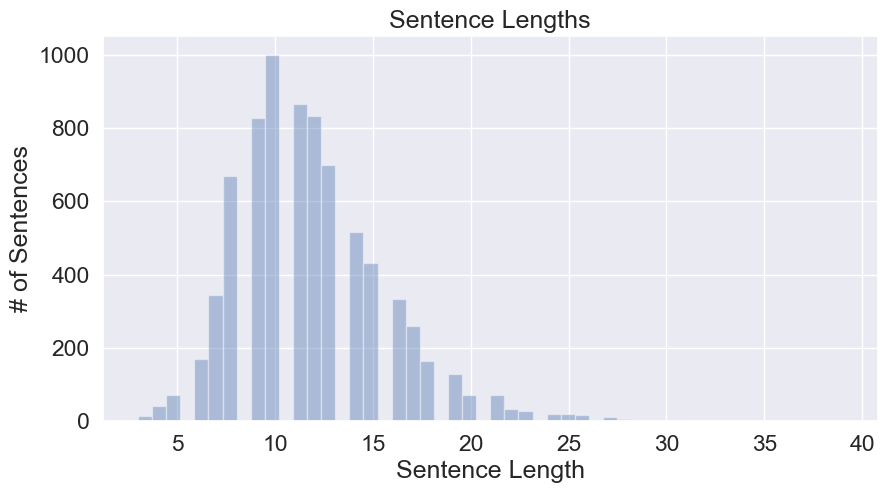

In [15]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')


These are some very short sentences!

Since we don't know what the longest sentence in the test set is, let's set the max_len to 50 to leave some room (the maximum training sentence length was 39 tokens).



### 3.3. Tokenize All Samples

Now we're ready to perform the real tokenization! 

> *Note that, to allow the BERT tokenizer to split "unknown" words into subwords, we're actually going to  reconstruct each sentence (by combining the tokens with white space) before feeding it to the tokenizer.*

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split unknown words into subwords.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length (we chose 50).
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens (so that the self-attention mechanism in BERT ignores the `[PAD]` tokens).

> *Since we don't know what the longest sentence in the test set is, let's set the max_len to 50 to leave some room (the maximum training sentence length was 39 tokens).*

In [16]:
max_len = 50

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    # Reconstruct the sentence--otherwise `tokenizer` will interpret the list
    # of string tokens as having already been tokenized by BERT.
    sent_str = ' '.join(sent)

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

c:\Users\santhoss\miniconda3\envs\ilabs\Lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Token IDs: tensor([ 101, 1016, 2707, 7884, 2007, 2503, 7759,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


### 3.4. Re-labelling and Adding Null Labels

We've prepared all of our sentences to feed into BERT, but there's a problem--we've added a bunch of tokens to the input sequences (special tokens, padding, and splitting "unknown" words) and now *the original token labels are no longer aligned with the tokens!*

To fix this, we'll define an additional token label that we'll give to any tokens that were added. You might call this the "null" label, or the "padding" label. 

So, for example if our sentence is "5 star resturants nearby with chorizo tacos," the words "resturants," "chorizo," and "tacos" all get tokenized into smaller subwords and need new labels:
![](https://drive.google.com/uc?id=1TnGVa13ufIq3Yu0v-eNuYH1BZaqcym-z)


We add null labels to each of the subsequent subword tokens and the result is the newly tokenized sentence that looks like this:


![](https://drive.google.com/uc?id=1YIMz23PbdzhYrBmzsICvLE-deuzgFRdK)

Our `label_map` dictionary, which we created while parsing the dataset, maps the token *label* strings to unique integer IDs. We'll add to this the integer ID `-100` to label any of these "added" tokens.

The following cell will update the list of token labels for each sentence by adding in the null label where needed.

In [18]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])


Sentence:     ['5', 'star', 'resturants', 'in', 'my', 'town']

Labels:       ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']

BERT Tokens:  ['5', 'star', 'rest', '##ura', '##nts', 'in', 'my', 'town']

Token IDs:    tensor([ 101, 1019, 2732, 2717, 4648, 7666, 1999, 2026, 2237,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])


In [19]:
# New labels for all of the input sentences.
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

# For each sentence...
for (sen, orig_labels) in zip(input_ids, labels):
    
    # Create a new list to hold the adjusted labels for this sentence.
    padded_labels = []

    # This will be our index into the original label list.
    orig_labels_i = 0 

    # For each token in the padded sentence...
    for token_id in sen:

        # Pull the value out of the tensor.
        token_id = token_id.numpy().item()

        # If `[PAD]`, `[CLS]`, or `[SEP]`...
        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            # Assign it the null label.
            padded_labels.append(null_label_id)

        # If the token string starts with "##"...
        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            # It's a subword token, and not part of the original dataset, so
            # assign it the null label.
            padded_labels.append(null_label_id)

        # If it's not any of the above...
        else:
            
            # This token corresponds to one of the original ones, so assign it
            # it's original label.

            # Look up the label for this token.
            label_str = orig_labels[orig_labels_i]

            # Map the label to its ID, and assign it.
            padded_labels.append(label_map[label_str])

            # Increment our index into the original labels list.
            orig_labels_i += 1

    # If we did this right, then the new `padded_labels` list should match
    # the length of the tokenized sentence.
    assert(len(sen) == len(padded_labels))    

    # Store the updated labels list for this sentence.
    new_labels.append(padded_labels)


Now, when we look at a real example sentence from our dataset we can see the result of these changes:

"5 star resturants in my town"

This sentence, like the one above, includes a misspelling of the word 'restaurant', so the BERT tokenizer splits this word into multiple subwords.

The first subword rest is given the original label, while ##ura and ##nts are labeled with ID -100.

In [20]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])



Sentence:     ['5', 'star', 'resturants', 'in', 'my', 'town']

Labels:       ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']

BERT Tokens:  ['5', 'star', 'rest', '##ura', '##nts', 'in', 'my', 'town']

Token IDs:    tensor([ 101, 1019, 2732, 2717, 4648, 7666, 1999, 2026, 2237,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

New Labels:   [-100, 13, 7, 12, -100, -100, 15, 11, 11, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

### 3.4. Python Lists to PyTorch Tensors

In [26]:
type(input_ids), type(new_labels), type(attention_masks)

(list, list, list)

In [27]:
len(input_ids), len(new_labels)

(7660, 7660)

In [28]:
len(input_ids[0]), len(new_labels[0])

(50, 50)

In [34]:
# Convert the lists into PyTorch tensors.

# `input_ids` is a list of tensor arrays--stack them into a matrix with size
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

# `attention_masks` is a list of tensor arrays--stack them into a matrix with
# size [7,660  x  50].
pt_attention_masks = torch.stack(attention_masks, dim=0)

# Labels is a list of lists. Convert it into a tensor matrix with size 
# [7,660  x  50].
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [35]:
pt_labels.shape

torch.Size([7660, 50])

In [36]:
pt_input_ids.shape

torch.Size([7660, 50])

# Part II - Fine Tuning of BERT
---------------------------

## S4. Training the Classifier

### 4.1. Loading the pre-trained BERT Model

Since it is a multi-class classification task, the output layer will be a Softmax Layer.

In [37]:
# This is the number of labels in our dataset, so we will be doing 18-way classification (all labels plus our padding label)
len(label_map)

17

In [38]:
# Load BertForTokenClassification 
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, # The number of output labels--18 for our NER dataset (+1 for ignore class)
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

desc = model.to(device)
desc

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## In the below cell, I've printed out the names and dimensions of the weights for:

* The embedding layer.
* The first of the twelve transformers.
* The output layer.

In [39]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.


==== Output Layer ====

bert.encoder.layer.11.output.LayerNorm.weight                 (768,)
bert.encoder.layer.11.output.LayerNorm.bias                   (768,)
classifier.weight                                          (18, 768)
classifier.bias                                                (18,)


we can see the O/P layer has 18 x 768 weights and 18 bias terms.

### 4.2. Training and validation Split

In [40]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(pt_input_ids, pt_labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(pt_attention_masks, pt_labels,
                                             random_state=2018, test_size=0.1)
                                             

print(f"Total number of Training Samples: {len(train_inputs)}")
print(f"Total number of Validation Samples: {len(validation_inputs)}")

Total number of Training Samples: 6894
Total number of Validation Samples: 766


## S4. Training Our Named Entity Recognizer

### 4.3. Batch Size and Data-loaders

### We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [41]:
# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### 4.4. Optimizer, Epochs and Learning Rate Scheduler

In [42]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


### 4.5 Helper Functions

In [43]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 4.6. Training Loop!

In [44]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids = None, 
                       attention_mask = b_input_mask, 
                       labels = b_labels,
                       return_dict = True)
        
        loss = result.loss

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    # Tracking variables 
    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            
            result = model(b_input_ids, 
                           token_type_ids = None, 
                           attention_mask = b_input_mask,
                           labels = b_labels,
                           return_dict = True)
            
            loss = result.loss
            logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
        


======== Epoch 1 / 4 ========
Training...


In [93]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.3848423891597324,
  'Valid. Loss': 0.267675365631779,
  'Training Time': '0:09:32',
  'Validation Time': '0:00:20'},
 {'epoch': 2,
  'Training Loss': 0.22512861165321535,
  'Valid. Loss': 0.2638976803670327,
  'Training Time': '0:10:02',
  'Validation Time': '0:00:21'},
 {'epoch': 3,
  'Training Loss': 0.16298579674697034,
  'Valid. Loss': 0.2799088458220164,
  'Training Time': '0:10:06',
  'Validation Time': '0:00:21'},
 {'epoch': 4,
  'Training Loss': 0.12503502874945602,
  'Valid. Loss': 0.2888439322511355,
  'Training Time': '0:10:07',
  'Validation Time': '0:00:21'}]

### 4.6. Visualization of Train and Validation Loss Vs. Epochs

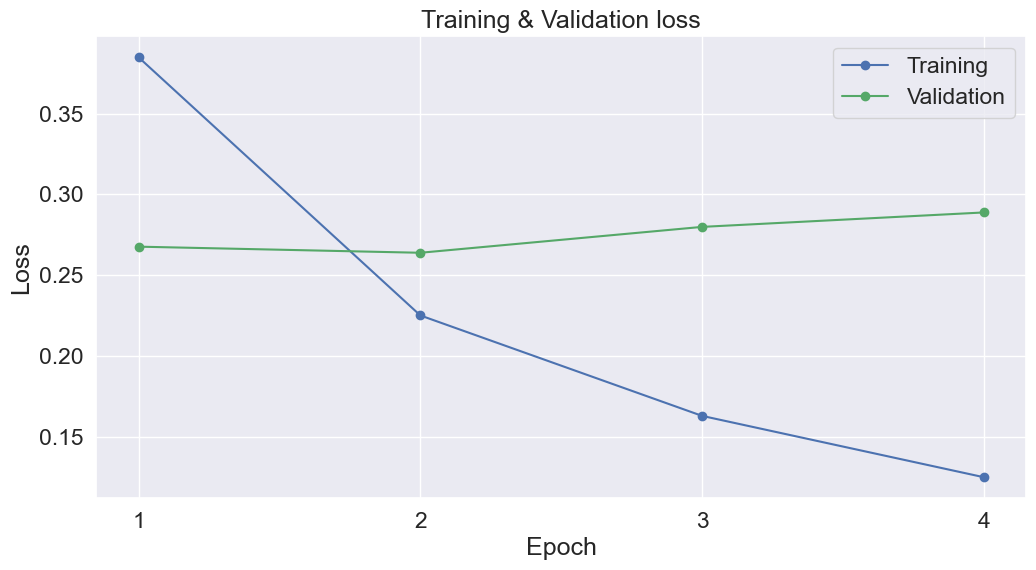

In [94]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [107]:
all_predictions = np.concatenate(predictions, axis=0)
all_labels = np.concatenate(true_labels, axis = 0)
all_labels.shape

all_labels[0]

array([-100,   14,   14,   14,    1,   13,   13,   13,   14,    8,   11,
         11, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100], dtype=int64)

# 5. Performance On Test Set
-----------

### 5.1. Data Preparation